In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tabulate import tabulate # pretty print tables

# Logistic Regression on the Olivetti Faces Dataset

We will train a Logistic Regression classifier to classify images of faces. This is a nice test bed for applying machine learning to problems of current interest. A modern counterpart to this computation would likely be a neural network learning to classify on datasets containing millions of faces. 

We will see that logistic regression already works well on these $64\times 64$ images, reaching an accuracy of $100\%$ on the train set and about $96\%$ 
on the test set.

Further, we will also take this opportunity to learn about data. In particular, using techniques from _unsupervised learning_ we find that though the data is written as
$64\times 64 = 4096$ dimensional vectors, it may be represented as vectors of much lower dimensionality. This appears quite generic to machine learning: even though
data appear to be live in high dimensional spaces, they can often be cast in lower dimensional spaces without losing much information.

In [2]:
faces = datasets.fetch_olivetti_faces()

In [3]:
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [4]:
x,y = faces.images, faces.target
print(x.shape, y.shape)

(400, 64, 64) (400,)


In [5]:
test_size = 0.4
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=test_size,stratify=y)
print(x_train.shape,x_test.shape)

(240, 64, 64) (160, 64, 64)


## Making a Pipeline

The data are images of shape $64\times 64$. Logistic Regression expects a vector input, not a 2d array. Hence, we would like to have a pipeline which:

1. Unrolls the input
2. Scales it as needed
3. Runs the classifier

This will also give us the opportunity to write a customized transformer for the data.

In [6]:
y_faces = np.unique(y_train)

idx_faces = [np.where(y_train==y)[0][0] for y in y_faces]

x_faces = x_train[idx_faces]
y_faces = y_train[idx_faces]

In [7]:
def get_sample_images(label,n):
    idx = np.where(y_train==label)[0][:n+1]
    return [x.reshape(64,64) for x in x_train[idx]]

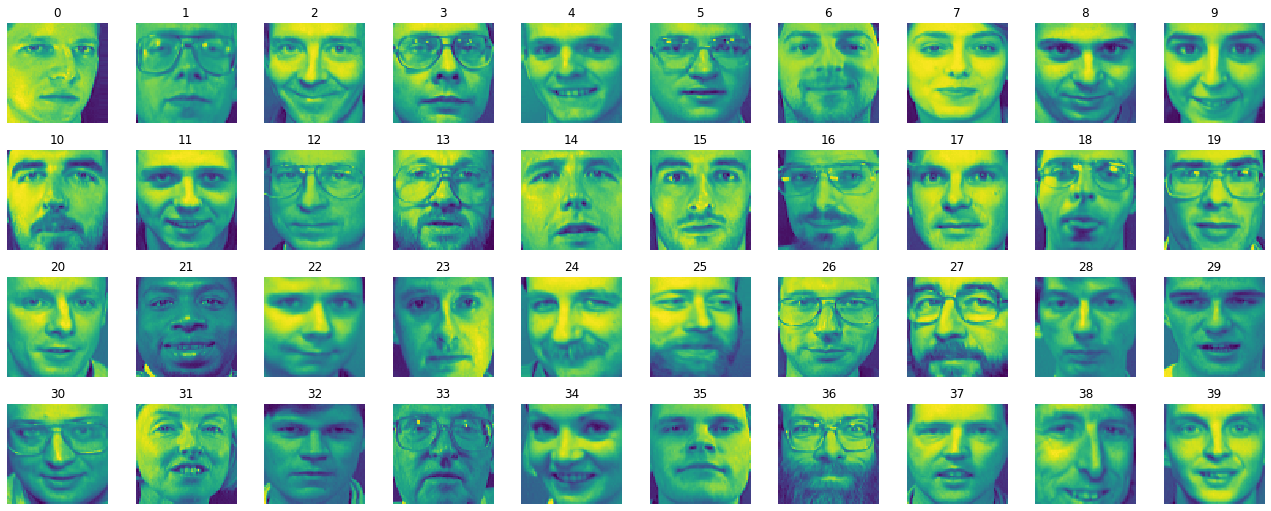

In [8]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.8, n_rows * 1.8))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_faces[index], cmap="viridis", interpolation="nearest")
        plt.axis('off')
        plt.title(y_faces[index], fontsize=12)
plt.tight_layout()
plt.savefig('olivetti.png',format='png')
plt.show()

In [9]:
x_train = x_train.reshape(*x_train.shape[:1],-1)
x_test = x_test.reshape(*x_test.shape[:1],-1)

In [10]:
x_train.shape

(240, 4096)

# Visualizing the Dataset as a Point Cluster

We can visualize the Faces dataset as a cluster by reducing down to two _principal components_. An overview of the method is [here](https://www.cs.cmu.edu/~elaw/papers/pca.pdf). The point cluster does not seem to give any obvious insights into the data, but it can be used for _dimensionality reduction_.

In [11]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(x_train)
X_2d.shape, np.cumsum(pca.explained_variance_)

((240, 2), array([18.439068, 28.976906], dtype=float32))

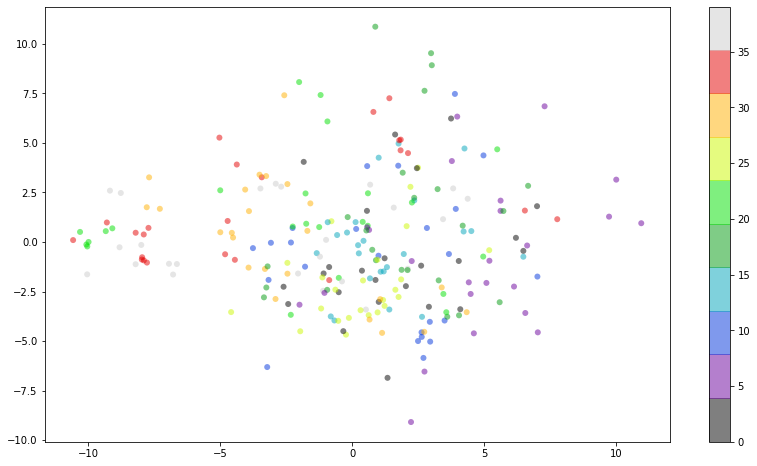

In [12]:
plt.figure(figsize=(14,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=y_train,edgecolor='none',alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

# The Logistic Regression Model

As mentioned before, we will use multinary Logistic Regression to classify this dataset. Further, we will use L1 regularization on the model. In addition to mitigating
overfitting, an additional benefit of L1 regularization is _feature selection_, i.e. it tends to drive down the magnitude of weights corresponding to features that turn out to be unimportant for the classification.

## Choosing Features

Our features will be the individual pixel values themselves. In particular, suppose an image $\mathcal{I}$ consists of pixels $p_{ij}$ located at position $ij$ on the image grid. Then our feature vector $\phi\left(\mathcal{I}\right)$ will be
\begin{equation}
\phi\left(\mathcal{I}\right)_k = p_{ij}, \qquad k \equiv \left(i,j\right)\,.
\end{equation}
Operationally, this means we can unroll the $2d$ $64\times 64$ images in <tt>x_train</tt> and <tt>x_test</tt> into $4096$ dimensional vectors which are then input into the Logistic Regression classifier.

As before, we will use <tt>sklearn</tt>'s <tt>LogisticRegression</tt> classifier, documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [46]:
std_scaler = StandardScaler()
log_reg = LogisticRegression(multi_class='multinomial',
                                 solver='saga',penalty='l1',C=1e3,
                                 max_iter=5000,tol=1e-3)
softmax_reg = Pipeline([("std_scaler", std_scaler),
                        ("log_reg", log_reg),])

In [47]:
softmax_reg.fit(x_train,y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=1000.0, max_iter=5000,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga', tol=0.001))])

In [48]:
y_pred = softmax_reg.predict(x_train)
print('accuracy reached on train set: ',accuracy_score(y_train,y_pred))

accuracy reached on train set:  1.0


In [49]:
y_pred = softmax_reg.predict(x_test)
print('accuracy reached on test set: ',accuracy_score(y_test,y_pred))

accuracy reached on test set:  0.9875


## Visualizing Feature Importance

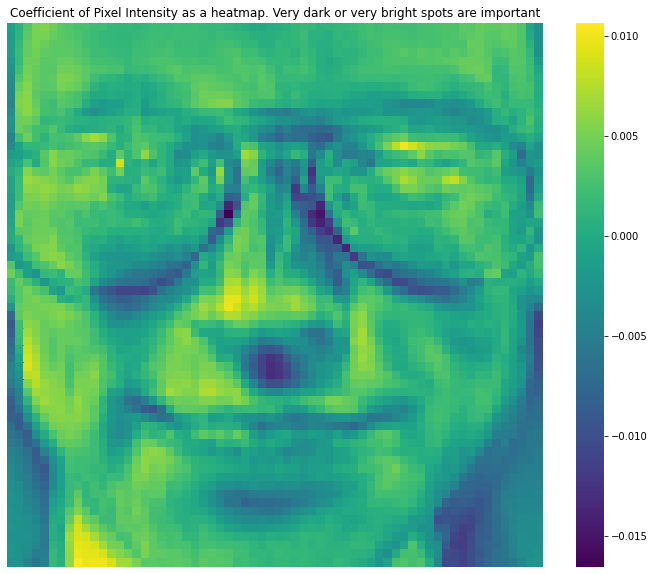

In [50]:
coefficients=softmax_reg['log_reg'].coef_

plt.figure(figsize=(12,10))
sns.heatmap(coefficients[26].reshape(64,64),cmap='viridis')
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
plt.title('Coefficient of Pixel Intensity as a heatmap. Very dark or very bright spots are important')
plt.show()

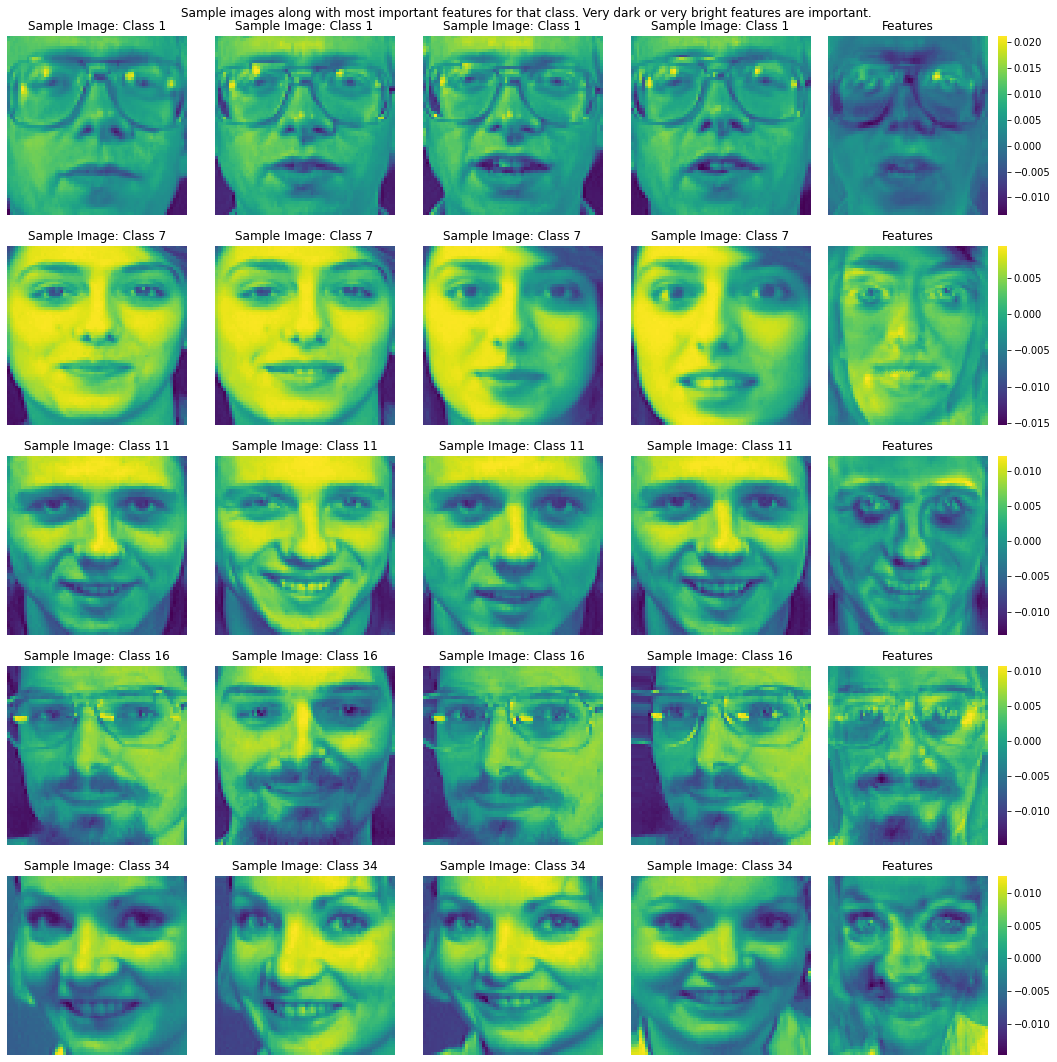

In [51]:
# a subset of classes to visualize important features on
face_subset = [1,7,11,16,34]
idx_faces = [np.where(y_train==y)[0][:5] for y in face_subset]

n_rows = 5
n_cols = 5
plt.figure(figsize=(n_cols * 3., n_rows * 3.))
plt.suptitle('Sample images along with most important features for that class. Very dark or very bright features are important.')
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        idx = idx_faces[row][col]
        face = face_subset[row]
        plt.subplot(n_rows, n_cols, index + 1)
        if col == n_cols-1:
            sns.heatmap(coefficients[face].reshape(64,64), cmap="viridis")
            plt.title('Features')
        else:
            plt.imshow(x_train[idx].reshape(64,64), cmap="viridis", interpolation="nearest")
            plt.title('Sample Image: Class {}'.format(y_train[idx]))
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

## Analyzing Misclassifications

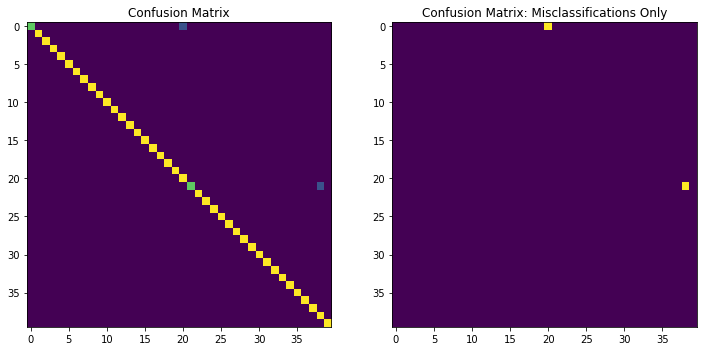

In [52]:
confusionmatrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(confusionmatrix)
plt.title('Confusion Matrix')
np.fill_diagonal(confusionmatrix,0)
plt.subplot(1,2,2)
plt.imshow(confusionmatrix)
plt.title('Confusion Matrix: Misclassifications Only')
plt.show()

The confusion matrix is mostly diagonal. In fact, the number of misclassifications is so few that we can explicitly study them on a case-by-case basis.

In [59]:
mismatch=np.where(y_test!=y_pred)[0]

test_act = y_test[mismatch]
test_pred = y_pred[mismatch]

# sample images from predicted class
faces_pred = [np.where(y_train==y)[0] for y in test_pred] 
# sample images from actual class
faces_act = [np.where(y_train==y)[0] for y in test_act]

table = {'actual id' : test_act, 'predicted id' : test_pred}
df = pd.DataFrame(table)
df.index+=1 # start row numbers from 1
print('Enumerating Misclassifications in Test Set')
print(tabulate(df, headers = 'keys', tablefmt = 'pretty'))

Enumerating Misclassifications in Test Set
+---+-----------+--------------+
|   | actual id | predicted id |
+---+-----------+--------------+
| 1 |    21     |      38      |
| 2 |     0     |      20      |
+---+-----------+--------------+


### Visualizing the Misclassifications

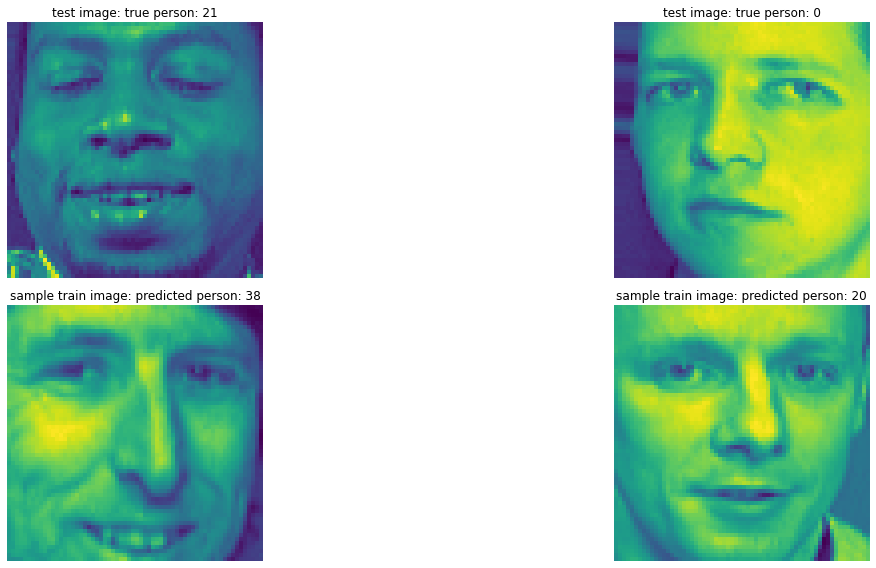

In [54]:
n_mismatch = len(mismatch)
fig, axes = plt.subplots(2,n_mismatch,figsize=(22,8))
for n,a in enumerate(axes[0]):
    a.imshow(x_test[mismatch[n]].reshape(64,64))
    a.axis('off')
    a.title.set_text('test image: true person: {}'.format(test_act[n]))
for n,a in enumerate(axes[1]):
    a.imshow(x_faces[test_pred[n]])
    a.title.set_text('sample train image: predicted person: {}'.format(test_pred[n]))
    a.axis('off')
plt.tight_layout()
plt.show()

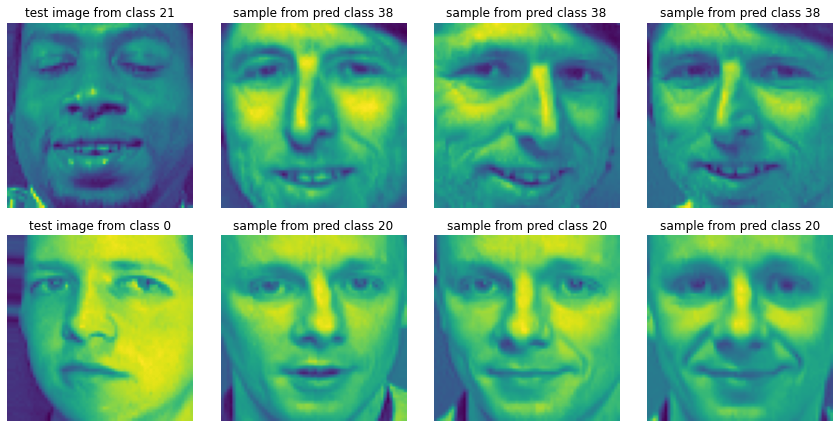

In [55]:
n_cols = 4
n_rows = len(mismatch)+1
plt.figure(figsize=(n_cols * 3., n_rows * 3.))
for row, m in enumerate(mismatch):
    test_img = x_test[mismatch[row]].reshape(64,64)
    pred_label = test_pred[row]
    sample_img = get_sample_images(pred_label,n_cols)
    for col in range(n_cols):
        index = n_cols * row + col
        ax=plt.subplot(n_rows,n_cols, index+1)
        plt.axis('off')
        if col == 0:#n_cols -1:
            ax.imshow(test_img)
            ax.title.set_text('test image from class {}'.format(test_act[row]))
        else:
            ax.imshow(sample_img[col])
            ax.title.set_text('sample from pred class {}'.format(test_pred[row])) # sample images of true label
plt.tight_layout()
plt.show()

# Dimensionality Reduction via Principal Components

In [60]:
pca = PCA() # by default all components are kept
_ = pca.fit_transform(x_train)

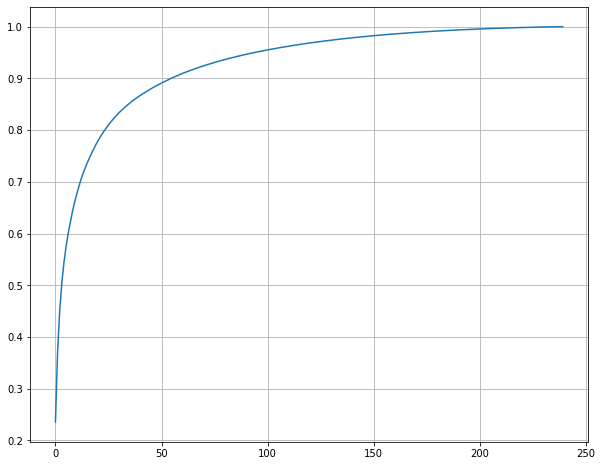

In [61]:
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid('both')

We see that most of the explained variance is contained in the first 50 dimensions, at which point an elbow appears in the graph. Including additional principal components leads to relatively lesser gain in explained variance. We therefore truncate to the first 100 components -- a little beyond the elbow -- and use them as features for Logistic Regression.

In [124]:
pca = PCA(n_components=100)
std_scaler = StandardScaler()
log_reg = LogisticRegression(multi_class='multinomial',
                                 solver='saga',penalty='l1',C=1e3,
                                 max_iter=5000,tol=1e-3)
softmax_reg = Pipeline([('pca',pca),
                        ("std_scaler", std_scaler),
                        ("log_reg", log_reg),])

In [125]:
softmax_reg.fit(x_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=100)),
                ('std_scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=1000.0, max_iter=5000,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga', tol=0.001))])

In [126]:
y_pred = softmax_reg.predict(x_train)
print('accuracy reached on train set: ',accuracy_score(y_train,y_pred))
y_pred = softmax_reg.predict(x_test)
print('accuracy reached on test set: ',accuracy_score(y_test,y_pred))

accuracy reached on train set:  1.0
accuracy reached on test set:  0.95625


### Aside: Vectors in PCA space

For amusement, let us try and visualize the PCA vectors in the parent $64\times 64$ dimensional space in which Olivetti Faces are defined. To do so, we first look at the zero vector in PCA space and map it back to the parent space and plot the resultant image. Next, we generate a random vector in the 50 dimensional principal component space and map it back to the parent space and plot them. The resultant images are a plausible instances for faces contained in the dataset.

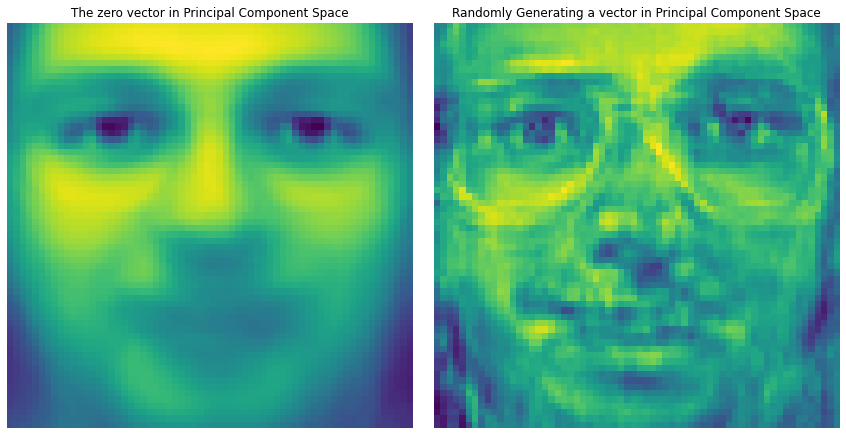

In [128]:
x_0 = np.zeros(100)
x_0_img = pca.inverse_transform(x_0).reshape(64,64)
x_random = np.random.rand(100)
x_rand_img = pca.inverse_transform(x_random).reshape(64,64)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(x_0_img)
plt.axis('off')
plt.title('The zero vector in Principal Component Space')
plt.subplot(1,2,2)
plt.imshow(x_rand_img)
plt.axis('off')
plt.title('Randomly Generating a vector in Principal Component Space')
plt.tight_layout()
plt.show()

## Analyzing Misclassifications

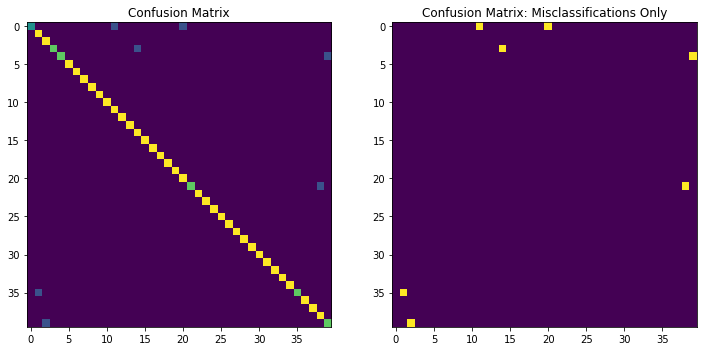

In [135]:
confusionmatrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(confusionmatrix)
plt.title('Confusion Matrix')
np.fill_diagonal(confusionmatrix,0)
plt.subplot(1,2,2)
plt.imshow(confusionmatrix)
plt.title('Confusion Matrix: Misclassifications Only')
plt.show()

In [133]:
mismatch=np.where(y_test!=y_pred)[0]

test_act = y_test[mismatch]
test_pred = y_pred[mismatch]

# sample images from predicted class
faces_pred = [np.where(y_train==y)[0] for y in test_pred] 
# sample images from actual class
faces_act = [np.where(y_train==y)[0] for y in test_act]

table = {'actual person' : test_act, 'predicted id' : test_pred}
df = pd.DataFrame(table)
df.index+=1 # start row numbers from 1
print('Enumerating Misclassifications in Test Set')
print(tabulate(df, headers = 'keys', tablefmt = 'pretty'))

Enumerating Misclassifications in Test Set
+---+---------------+--------------+
|   | actual person | predicted id |
+---+---------------+--------------+
| 1 |      21       |      38      |
| 2 |      39       |      2       |
| 3 |       3       |      14      |
| 4 |       4       |      39      |
| 5 |      35       |      1       |
| 6 |       0       |      11      |
| 7 |       0       |      20      |
+---+---------------+--------------+


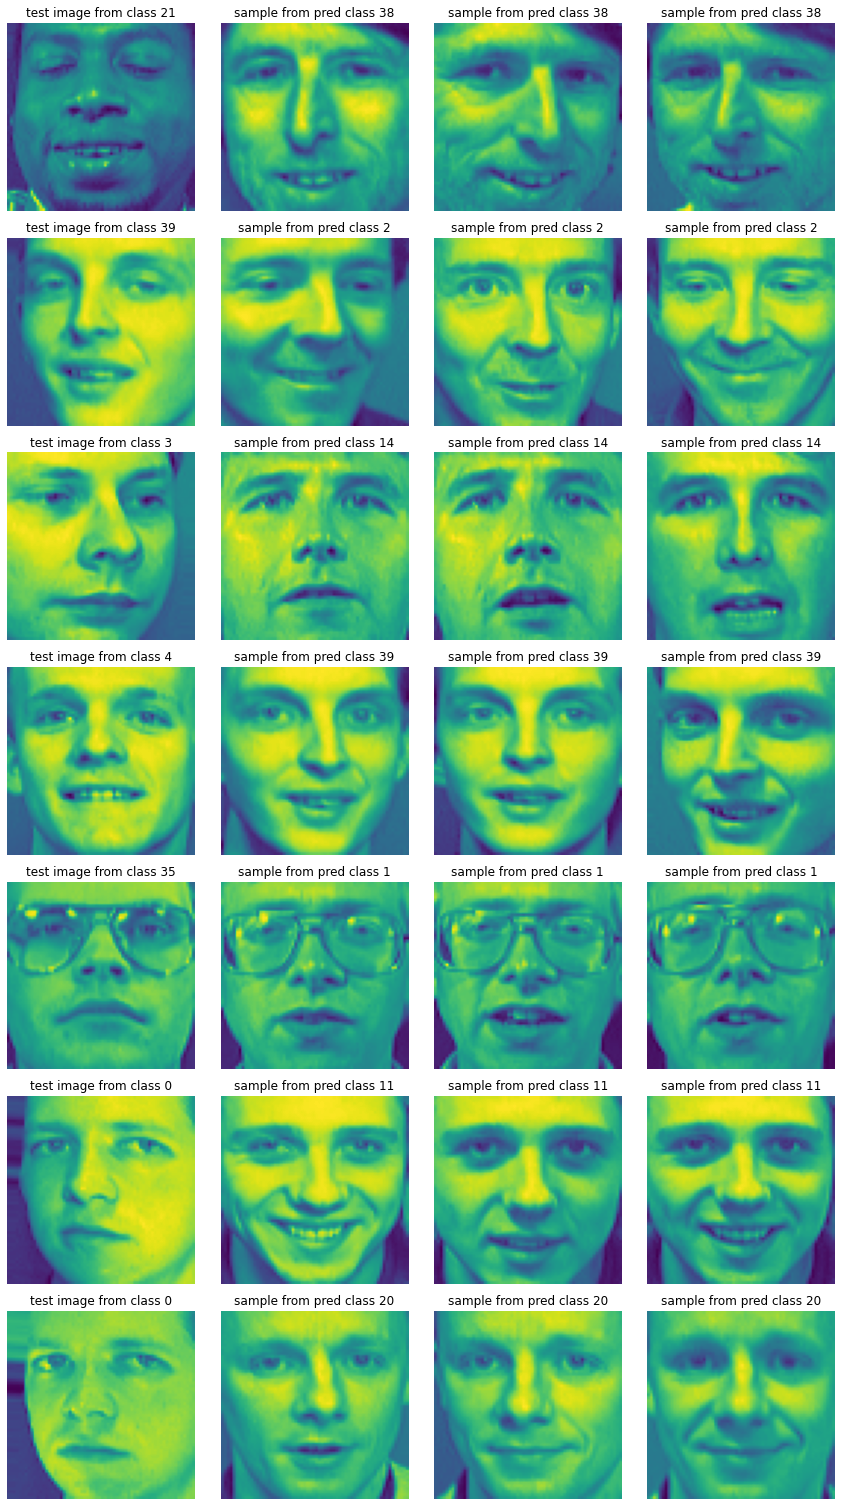

In [134]:
n_cols = 4
n_rows = len(mismatch)+1
plt.figure(figsize=(n_cols * 3., n_rows * 3.))
for row, m in enumerate(mismatch):
    test_img = x_test[mismatch[row]].reshape(64,64)
    pred_label = test_pred[row]
    sample_img = get_sample_images(pred_label,n_cols)
    for col in range(n_cols):
        index = n_cols * row + col
        ax=plt.subplot(n_rows,n_cols, index+1)
        plt.axis('off')
        if col == 0:#n_cols -1:
            ax.imshow(test_img)
            ax.title.set_text('test image from class {}'.format(test_act[row]))
        else:
            ax.imshow(sample_img[col])
            ax.title.set_text('sample from pred class {}'.format(test_pred[row])) # sample images of true label
plt.tight_layout()
plt.show()

In most cases the misclassifications are plausible in the sense that even a human could be expected to make these mistakes.